In [2]:
import os 
from typing import List, Dict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage 
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from tavily import TavilyClient

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

**Loading Documents to VectorDB**

In [4]:
embeddings_fn = OpenAIEmbeddings(
    model="text-embedding-3-large",
    api_key=os.getenv("OPEN_AI_API_KEY")
)

In [5]:
vector_store = Chroma(
    collection_name="udacity",
    embedding_function=embeddings_fn
)

file_path = "compact-guide-to-large-language-models.pdf"
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(pages)

_ = vector_store.add_documents(documents=all_splits)

In [6]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    api_key=os.getenv("OPEN_AI_API_KEY")
)

In [7]:
class State(MessagesState):
    question: str
    documents: List[Document]
    search_required: str = "NO"
    answer: str

In [8]:
def retrieve(state: State):
    question = state["question"]
    retrieved_docs = vector_store.similarity_search(question)
    return {"documents": retrieved_docs}

In [9]:
def evaluator(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    
    template = ChatPromptTemplate([
        ("system", "You are an assistant for evaluating context."),
        ("human", "Use the following pieces of retrieved context to determine if an " 
                  "additional search is required. If the context is relevant to the " 
                  "question, your response should be 'NO', i.e. no need for search. "
                  "If the context is not relevant, say 'YES', i.e. search the web for an answer. " 
                  "Don't explain anything, if it's to search the web, say YES, otherwise, NO. "
                  "\n# Question: \n-> {question} "
                  "\n# Context: \n-> {context} "
                  "\n# Answer: "),
    ])

    chain = template | llm | StrOutputParser()

    search_required = chain.invoke(
        {"context": docs_content, "question": question}
    )

    return {"search_required": search_required}
    

In [10]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(question)
    return response

In [11]:
llm_with_tools = llm.bind_tools([web_search])

In [12]:
def researcher(state: State):
    question = state["question"]
    messages = state["messages"]
    if not messages:
        human_message = HumanMessage(
            "Conduct a web research to findout the answer to the following question: "
            f"```{question}```"
        )
        messages = [human_message]
    
    ai_message = llm_with_tools.invoke(messages)
    messages.append(ai_message)
    return {"messages": messages, "answer": ai_message.content}

In [13]:
def augment(state: State):
    question = state["question"]
    documents = state["documents"]
    docs_content = "\n\n".join(doc.page_content for doc in documents)
    
    template = ChatPromptTemplate([
        ("system", "You are an assistant for question-answering tasks."),
        ("human", "Use the following pieces of retrieved context to answer the question. "
                "If you don't know the answer, just say that you don't know. " 
                "Use three sentences maximum and keep the answer concise. "
                "\n# Question: \n-> {question} "
                "\n# Context: \n-> {context} "
                "\n# Answer: "),
    ])

    messages = template.invoke(
        {"context": docs_content, "question": question}
    ).to_messages()

    return {"messages": messages}

In [14]:
def generate(state: State):
    ai_message = llm.invoke(state["messages"])
    return {"answer": ai_message.content, "messages": ai_message}

In [29]:
def rag_router(state: MessagesState):
    search_required = state.get("search_required", "NO")
    if search_required.lower() == "yes":
        return "researcher"

    return "augment"

In [30]:
def tool_router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "web_search"

    return END

In [31]:
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)
workflow.add_node("augment", augment)
workflow.add_node("generate", generate)
workflow.add_node("evaluator", evaluator)
workflow.add_node("researcher", researcher)
workflow.add_node("web_search", ToolNode([web_search]))

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "evaluator")

workflow.add_conditional_edges(
    source="evaluator", 
    path=rag_router, 
    path_map=["augment", "researcher"]
)

workflow.add_conditional_edges(
    source="researcher", 
    path=tool_router, 
    path_map=["web_search", END]
)
workflow.add_edge("web_search", "researcher")

workflow.add_edge("augment", "generate")
workflow.add_edge("generate", END)


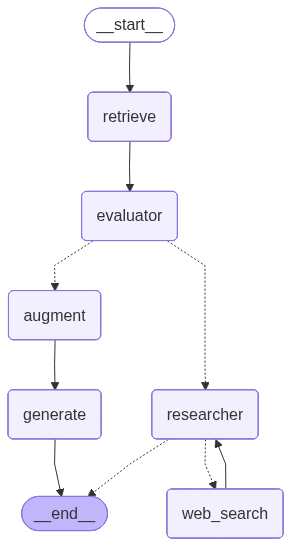

In [32]:
graph = workflow.compile()
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [33]:
output = graph.invoke(
    input={"question": "What is Pokemon?"},
)

In [34]:
output["answer"]

"I don't know."

In [35]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. 
# Question: 
-> What is Pokemon? 
# Context: 
-> 4
A Compact Guide to Large Language Models
What are language models and how do they work?
Large language models are advanced artificial intelligence systems that take 
some input and generate humanlike text as a response. They work by first 
analyzing vast amounts of data and creating an internal structure that models 
the natural language data sets that they’re trained on. Once this internal 
structure has been developed, the models can then take input in the form of 
natural language and approximate a good response. 
 
If they’ve been aroun

In [36]:
output["search_required"]

'YES'

In [37]:
output = graph.invoke(
    input={"question": "What is Open Source model?"},
)

In [38]:
output["search_required"]

'NO'

In [39]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an assistant for question-answering tasks.
================================ Human Message =================================

Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. 
# Question: 
-> What is Open Source model? 
# Context: 
-> 7
A Compact Guide to Large Language Models
It does currently take a little bit more work to grab an open source model and 
start using it, but progress is moving very quickly to make them more accessible 
to users. On Databricks, for example, we’ve made improvements to open source 
frameworks like MLflow to make it very easy for someone with a bit of Python 
experience to pull any Hugging Face transformer model and use it as a Python 
object. Oftentimes, you can find an open source model that solves your specific 
problem that is or